# Hyper parameters Optimization with Keras Tuner

In this section we perform hyper parameters' optimization using Keras' tuner.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PieTempesti98/CNNMalariaDetector/blob/master/HyperParametersOptimization%20(1).ipynb)

In [1]:
# imports
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import activations
from tensorflow.keras.utils import plot_model
from tensorflow import keras as ks
from sklearn import metrics

from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np

import os

In [2]:
# global parameters
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256
SEED = 20

In [3]:
# set always the same seed i order to obtain reproducible results
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# path settings and mount of google drive folders

PROJECT_DIR_PATH = "/content/drive/MyDrive/Colab Notebooks/cidl_project"
MODELS_DIR_PATH = "/models/"
IMAGES_DIR_PATH = "/images/"
HPO_PATH = './hyperparam_optimization_malariaCNN'

# mount google drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Dataset import and pre-processing

In this subsection we import the dataset and we peform some pre-processing operations over it.

In [5]:
# load malaria dataset from Tensorflow and split it in train, test and validation
(train_ds, val_ds, test_ds), info = tfds.load(
    'malaria',
    as_supervised=True,
    split=['train[:80%]','train[80%:85%]', 'train[85%:]'],
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteVIHB4O/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


### Image rescaling
All the images are rescaled to a 120x120 size.

In [6]:
# image rescaling
@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (120, 120)) # Resizing the image to 120x120 dimension
    return (image, label)

In [7]:
# mapping of all the sets

train_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    val_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [8]:
# Model evaluation function
def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  model = ks.models.load_model(PROJECT_DIR_PATH + MODELS_DIR_PATH + 'HPO_model.h5')
  y_score = model.predict(test_ds)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_ds], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Hyper Parameters Optimization

In this section we perform with Keras Tuner the fine-tuning of the following hyper parameters:
- activation function
- number of neurons
- learning rate



In [9]:
# tuner installation and import
!pip install -U keras-tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.0 MB/s eta 0:00:00


In [10]:
# Hypermodel's building function
def model_builder(hp):
  '''
        build an hypermodel
        :param hp: hyperparameters used to build the hypermodel
    '''
  # activation function
  activation_hp = hp.Choice('activation_function', values=['relu', 'tanh'])

  # number of units in the dense layer ([128, 256])
  n_units_hp = hp.Int('n_units_dl', min_value=128, max_value=256, step=32)

  # optimizer learning rate ({0.01, 0.001, 0.0001})
  learning_rate_hp = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # build the model
  inputs = ks.Input(shape=(120,120,3))
  x = layers.Conv2D(32, (3, 3), activation=activation_hp)(inputs)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation=activation_hp)(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Conv2D(128, (3, 3), activation=activation_hp)(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Conv2D(256, (3, 3), activation=activation_hp)(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(n_units_hp, activation=activation_hp)(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  model = ks.Model(inputs=inputs, outputs=outputs, name="optimized_model")

  # model compilation
  model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate_hp),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
  
  model.summary()

  return model

### Hyperband Tuning
Using the **Hyperband** method we fine-tune CNN's hyperparameters and to **prevent over-fitting** we use an early stopping call-back function that monitors the *loss on validation* and with *patient = 3*, so that it stops if for 3 epochs the loss hasn't changed.

In [11]:
# define the tuner with Hyperband method
tuner = kt.Hyperband(hypermodel = model_builder,
                     objective='val_binary_accuracy',
                     overwrite=True,
                     max_epochs=15,
                     factor=3,
                     hyperband_iterations=3,
                     seed = SEED,
                     directory="./hpo",
                     project_name="hyperparam_optimization_malariaCNN"
                    )

# call-back function for early termination
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Model: "optimized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)   

In [12]:
# Run hyper parameters' search
tuner.search_space_summary()

tuner.search(train_ds, epochs=15, validation_data=val_ds, callbacks=[stop_early])

Trial 90 Complete [00h 04m 45s]
val_binary_accuracy: 0.9506531357765198

Best val_binary_accuracy So Far: 0.958635687828064
Total elapsed time: 02h 26m 15s


In [13]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter search completed. The optimal number of units in the first densely-connected
layer is {best_hps.get('n_units_dl')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, and the optimal activation founction is {best_hps.get('activation_function')}.
""")

tuner.results_summary()


Hyperparameter search completed. The optimal number of units in the first densely-connected
layer is 160, the optimal learning rate for the optimizer
is 0.001, and the optimal activation founction is relu.

Results summary
Results in ./hpo/hyperparam_optimization_malariaCNN
Showing 10 best trials
Trial summary
Hyperparameters:
activation_function: relu
n_units_dl: 160
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0083
Score: 0.958635687828064
Trial summary
Hyperparameters:
activation_function: tanh
n_units_dl: 192
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.9579100012779236
Trial summary
Hyperparameters:
activation_function: tanh
n_units_dl: 224
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.9571843147277832
Trial summary
Hyperparameters:
activation_function: tanh
n_unit

## HPO-model's training
Given the set of optimal hyper parameters, now we build the tuned model, we train it and we evaluate it.

In [14]:
# build the model using the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# define call-back for check-point
check_point = ks.callbacks.ModelCheckpoint(
                        filepath = PROJECT_DIR_PATH + MODELS_DIR_PATH + "HPO_model" + '.h5',
                        monitor="val_loss", 
                        verbose=1,
                        save_best_only=True)

# train the model
history = model.fit(train_ds, epochs=30, shuffle=True, validation_data=val_ds, callbacks = [stop_early, check_point])

Model: "optimized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)   

17/17 [==============================] - 3s 154ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9721    0.9348    0.9531      2086
           1     0.9361    0.9727    0.9540      2048

    accuracy                         0.9536      4134
   macro avg     0.9541    0.9537    0.9536      4134
weighted avg     0.9543    0.9536    0.9535      4134



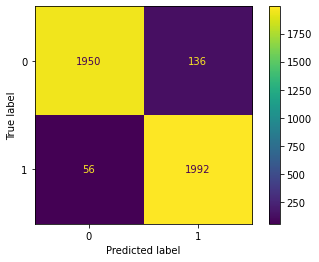

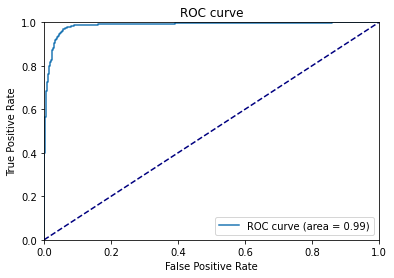

In [15]:
# evaluate model
evaluate_model(model)

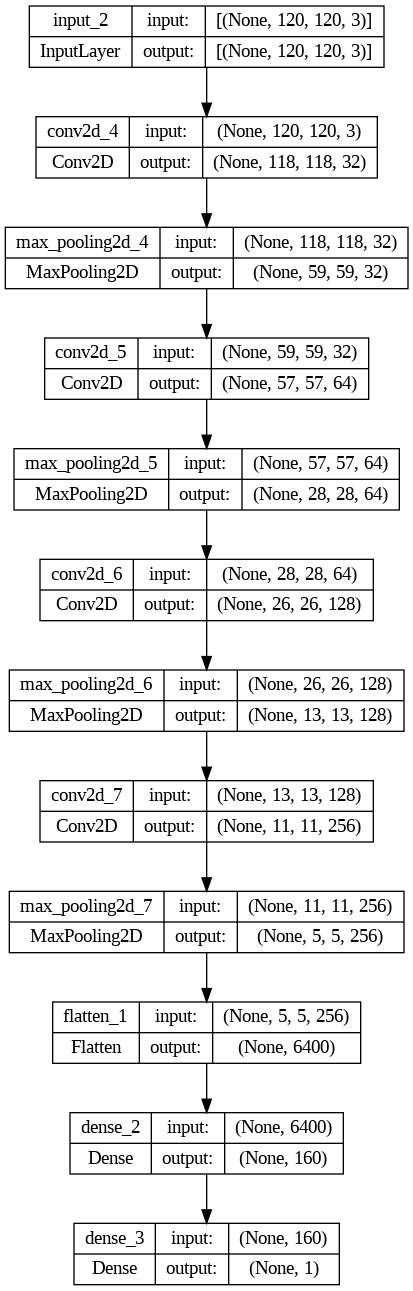

Model: "optimized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)   

In [16]:
from IPython.core.display import Image

IMG_PATH = PROJECT_DIR_PATH + IMAGES_DIR_PATH

# display model structure
plot_model(model, 'HPO_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="HPO_model.png"))
!cp -r './HPO_model.png' IMG_PATH

# show model summary
model.summary()

In [17]:
# clean the directories
! rm -r HPO_PATH
! rm -r "./hpo"

rm: cannot remove 'HPO_PATH': No such file or directory
